# **Introduction**

As COVID-19 became more and more of a politically divisive issue, we were interested in the intersection of social media, political sentiment, and the pandemic. The Republicans, on average, are seen pushing towards an "anti-mask" platform, with Donald Trump stating quotes like: “I wore one” — a mask — “in the back area. I didn’t want to give the press the pleasure of seeing it.” The Democrats, on the other hand, are pushing with a "pro-mask" platform. 



---



With the power of social media, citizens are pouring out tweets about the pandemic, and our point of interest was to see how much information we can really gain off of just tweets. 


Moreover, our goal in this project is to :

1. Predict the number of deaths that will occur in the location of a given tweet
2. Predict if the tweet was tweeted in a Republican or Democratic State





# **Getting Data**






We first bring in data from two datasets. 

Because the files were too large, we were unable to upload them online to Github and moreover they can be found here: 


1.   https://healthdata.gov/dataset/united-states-covid-19-cases-and-deaths-state-over-time
2.   https://www.kaggle.com/gpreda/covid19-tweets





df contains a large file of tweets including information like the date, text, location, and hashtags in the tweet.

df_cases is a CDC dataset including all of the daily deaths that occured for every state throughout the pandemic.

In [ ]:
import pandas as pd

df = pd.read_csv('/content/covid19_tweets.csv')
df_cases = pd.read_csv('/content/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

##Initial Cleaning of Data##

Changing the Date Columns


> Ultimately, we want to merge df with df_cases on the corresponding state and the date, so that our dataframe will have the number of deaths as the label. Moreover, we convert the dates to strings to make them easily comparable.

In [ ]:
from datetime import datetime

df['date']= pd.to_datetime(df['date'])
df_cases['submission_date'] = pd.to_datetime(df_cases['submission_date'])

def convert_date(argument):
  return datetime.strftime(argument, '%D')

df['date'] = df['date'].apply(lambda x: convert_date(x))
df_cases['submission_date'] = df_cases['submission_date'].apply(lambda x: convert_date(x))

We immediately drop the user name and its creation date since it will be unecessary

In [ ]:
df = df.drop(["user_name", "user_created"], axis=1)

We print the datatypes to confirm that Pandas interpreted our data correctly, and will correctly enter our machine learning models.

In [ ]:
df["user_location"]= df["user_location"].astype(str) 
df.dtypes

user_location       object
user_description    object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
hashtags            object
source              object
is_retweet            bool
dtype: object

##Scraping States from the Dataframe##

> The current dataframe includes many international, unknown, and fictional locations such as "astroworld," so we scrape the correct location data by matching keywords. 



> We want our states to be in the two letter format, so we either directly take the abbreviations from the text. If the full length of the state is given, we map it to its abbreviation.





In [ ]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

states_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", 
               "Arizona", "California", "Colorado", "Connecticut", 
               "District ", "of Columbia", "Delaware", "Florida", 
               "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", 
               "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
               "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi",
               "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", 
               "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", 
               "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", 
               "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington",
               "Wisconsin", "West Virginia", "Wyoming"]


us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

popular_cities = {
    'Los Angeles': 'CA',
}

def filterState(argument):
  if (argument == None):
    return None
  if (any(substring in argument for substring in states)):
    for i in range(len(states)):
      if (states[i] in argument):
        return states[i]
  elif (any(substring in argument for substring in states_names)):
    for i in range(len(states_names)):
      if (states_names[i] in argument):
        return us_state_abbrev.get(states_names[i])
  return None


Applying the scraping function and dropping nil values

In [ ]:
df["user_location"] = df["user_location"].apply(lambda x: filterState(x))
df.dropna(subset=['user_location'], how='all', inplace=True)

# **Exploratory Data Analysis**

Another data point we wanted to collect was the counts on the number of hashtags used other than simply #Covid19. In order to do this, we first collected all the hashtags into a single array, then merged them with our original dataframe. 

In [ ]:
import numpy as np
from ast import literal_eval
pd.options.mode.chained_assignment = None

ht_array = df['hashtags'].dropna().to_numpy()
def toArray(array):
  arr = []
  for i in array:
    arr.append(literal_eval(i.lower()))
  return arr
new_array = np.hstack(toArray(ht_array))
def wordListToFreqDict(words):
    wordlist = list(words)
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))
freq = wordListToFreqDict(new_array)

counts = pd.DataFrame(freq.keys())
counts['values'] = freq.values()
counts = counts.sort_values(by = 'values', ascending = False)
counts['keys'] = counts[0]

vlist = list(counts['keys'].head(15))
print(vlist)
df = df.reset_index(drop = True)
for v in vlist:
  df1 = df.dropna(subset = ['hashtags'])
  mask = ([v in s.lower() for s in df1['hashtags']])*1
  df1[v + '_hashtag'] = mask
  df1[v + '_hashtag'] = df1[v + '_hashtag'].astype(int)
  fake = df.merge(df1, how = 'left', on = 'text')
  df[v + '_hashtag'] = fake[v + '_hashtag']
  df[v + '_hashtag'] = df[v + '_hashtag'].replace(np.nan, 0)
df.head(5)

['covid19', 'coronavirus', 'pandemic', 'trump', 'covid', 'wearamask', 'trumpvirus', 'florida', 'usa', 'socialdistancing', 'masks', 'maskup', 'vaccine', 'scams', 'covid_19']


,user_location,user_description,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,covid19_hashtag,coronavirus_hashtag,pandemic_hashtag,trump_hashtag,covid_hashtag,wearamask_hashtag,trumpvirus_hashtag,florida_hashtag,usa_hashtag,socialdistancing_hashtag,masks_hashtag,maskup_hashtag,vaccine_hashtag,scams_hashtag,covid_19_hashtag
0,NY,"Husband, Father, Columnist & Commentator. Auth...",2253,1677,24,True,07/25/20,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,KY,#Christian #Catholic #Conservative #Reagan #Re...,9275,9525,7254,False,07/25/20,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FL,Workplace tips and advice served up in a frien...,79956,54810,3801,False,07/25/20,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']",Buffer,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FL,COVID-19 Practice of Lechner Law,14,24,74,False,07/25/20,COVID Update: The infection rate in Florida is...,NaN,Twitter for iPad,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CA,Latest #Africa & #MENA related #News releases ...,10661,6,2037,True,07/25/20,Coronavirus - South Africa: COVID-19 update fo...,NaN,Africa Newsroom,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We did the exact same process with the text in the actual tweets. However, with the text there were certain words we did not want to include in the analysis due to their frequency in all tweets, not just Covid related tweets. Therefore, we removed the stopwords from the tweets, and then performed a similar analysis to the text as we did for the hashtags.

In [ ]:
stopwords = ['a', 'about', 'above', 'across', 'after', 'afterwards']
stopwords += ['again', 'against', 'all', 'almost', 'alone', 'along']
stopwords += ['already', 'also', 'although', 'always', 'am', 'among']
stopwords += ['amongst', 'amoungst', 'amount', 'an', 'and', 'another']
stopwords += ['any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere']
stopwords += ['are', 'around', 'as', 'at', 'back', 'be', 'became']
stopwords += ['because', 'become', 'becomes', 'becoming', 'been']
stopwords += ['before', 'beforehand', 'behind', 'being', 'below']
stopwords += ['beside', 'besides', 'between', 'beyond', 'bill', 'both']
stopwords += ['bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant']
stopwords += ['co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de']
stopwords += ['describe', 'detail', 'did', 'do', 'done', 'down', 'due']
stopwords += ['during', 'each', 'eg', 'eight', 'either', 'eleven', 'else']
stopwords += ['elsewhere', 'empty', 'enough', 'etc', 'even', 'ever']
stopwords += ['every', 'everyone', 'everything', 'everywhere', 'except']
stopwords += ['few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first']
stopwords += ['five', 'for', 'former', 'formerly', 'forty', 'found']
stopwords += ['four', 'from', 'front', 'full', 'further', 'get', 'give']
stopwords += ['go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her']
stopwords += ['here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers']
stopwords += ['herself', 'him', 'himself', 'his', 'how', 'however']
stopwords += ['hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed']
stopwords += ['interest', 'into', 'is', 'it', 'its', 'itself', 'keep']
stopwords += ['last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made']
stopwords += ['many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine']
stopwords += ['more', 'moreover', 'most', 'mostly', 'move', 'much']
stopwords += ['must', 'my', 'myself', 'name', 'namely', 'neither', 'never']
stopwords += ['nevertheless', 'next', 'nine', 'no', 'nobody', 'none']
stopwords += ['noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of']
stopwords += ['off', 'often', 'on','once', 'one', 'only', 'onto', 'or']
stopwords += ['other', 'others', 'otherwise', 'our', 'ours', 'ourselves']
stopwords += ['out', 'over', 'own', 'part', 'per', 'perhaps', 'please']
stopwords += ['put', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed']
stopwords += ['seeming', 'seems', 'serious', 'several', 'she', 'should']
stopwords += ['show', 'side', 'since', 'sincere', 'six', 'sixty', 'so']
stopwords += ['some', 'somehow', 'someone', 'something', 'sometime']
stopwords += ['sometimes', 'somewhere', 'still', 'such', 'system', 'take']
stopwords += ['ten', 'than', 'that', 'the', 'their', 'them', 'themselves']
stopwords += ['then', 'thence', 'there', 'thereafter', 'thereby']
stopwords += ['therefore', 'therein', 'thereupon', 'these', 'they']
stopwords += ['thick', 'thin', 'third', 'this', 'those', 'though', 'three']
stopwords += ['three', 'through', 'throughout', 'thru', 'thus', 'to']
stopwords += ['together', 'too', 'top', 'toward', 'towards', 'twelve']
stopwords += ['twenty', 'two', 'un', 'under', 'until', 'up', 'upon']
stopwords += ['us', 'very', 'via', 'was', 'we', 'well', 'were', 'what']
stopwords += ['whatever', 'when', 'whence', 'whenever', 'where']
stopwords += ['whereafter', 'whereas', 'whereby', 'wherein', 'whereupon']
stopwords += ['wherever', 'whether', 'which', 'while', 'whither', 'who']
stopwords += ['whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with']
stopwords += ['within', 'without', 'would', 'yet', 'you', 'your']
stopwords += ['yours', 'yourself', 'yourselves']

We first collected a list of words and counted those words among all of the tweets. We then found the 30 most commonly used words, and filtered out even more stopwords in order to collect "words of interest". Finally, we found the frequencies of these words in our text and added them to the dataframe.

In [ ]:
import numpy as np
from ast import literal_eval
import collections
pd.options.mode.chained_assignment = None

text_array = df['text'].dropna().to_numpy()
def splitArray(array):
  arr = []
  for i in array:
    arr.append(i.split())
  return arr
text_array = splitArray(text_array)
text_array
new_array = np.hstack((text_array))
new_array
wordlist = [w for w in new_array if w not in stopwords]


counts_no_urls = collections.Counter(wordlist)

print(counts_no_urls.most_common(30))

words_of_interest = ['pandemic', 'vaccine', '@realDonalTrump', 'people', 'new', 'cases', 'health', 'deaths', 'death', 'need', 'mask', 'patient', 'school', 'Trump']
def wordListToFreqDict(words):
    wordlist = list(words)
    wordlist = [w for w in wordlist if w not in stopwords]
    wordlist = [w for w in wordlist if w in words_of_interest]
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))
freq2 = wordListToFreqDict(new_array)

counts = pd.DataFrame(freq2.keys())
counts['values'] = freq2.values()
counts = counts.sort_values(by = 'values', ascending = False)
counts['keys'] = counts[0]
counts_prelim = counts.head(12)

vlist2 = list(counts_prelim['keys'].head(15))
for v in vlist2:
  mask = df['text'].apply(str.lower).str.contains(v)*1
  df[v + "_text"] = mask
df.head(5)


[('#COVID19', 15447), ('I', 3780), ('The', 3262), ('&amp;', 2681), ('-', 2479), ('#covid19', 1790), ('people', 1678), ('cases', 1652), ('new', 1636), ('COVID-19', 1352), ('This', 1302), ('We', 1263), ('@realDonaldTrump', 1181), ('#coronavirus', 1176), ('#Covid19', 1026), ('|', 1025), ('#COVID19.', 989), ('A', 945), ('just', 934), ('like', 925), ('If', 861), ('deaths', 835), ('need', 829), ('In', 804), ('How', 789), ('Pandemic', 763), ('help', 756), ('New', 750), ('pandemic', 742), ('health', 714)]


,user_location,user_description,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,covid19_hashtag,coronavirus_hashtag,pandemic_hashtag,trump_hashtag,covid_hashtag,wearamask_hashtag,trumpvirus_hashtag,florida_hashtag,usa_hashtag,socialdistancing_hashtag,masks_hashtag,maskup_hashtag,vaccine_hashtag,scams_hashtag,covid_19_hashtag,people_text,cases_text,new_text,deaths_text,need_text,pandemic_text,health_text,Trump_text,mask_text,school_text,death_text,vaccine_text
0,NY,"Husband, Father, Columnist & Commentator. Auth...",2253,1677,24,True,07/25/20,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
1,KY,#Christian #Catholic #Conservative #Reagan #Re...,9275,9525,7254,False,07/25/20,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
2,FL,Workplace tips and advice served up in a frien...,79956,54810,3801,False,07/25/20,How #COVID19 Will Change Work in General (and ...,"['COVID19', 'Recruiting']",Buffer,False,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
3,FL,COVID-19 Practice of Lechner Law,14,24,74,False,07/25/20,COVID Update: The infection rate in Florida is...,NaN,Twitter for iPad,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0
4,CA,Latest #Africa & #MENA related #News releases ...,10661,6,2037,True,07/25/20,Coronavirus - South Africa: COVID-19 update fo...,NaN,Africa Newsroom,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0


##HashTag and Text EDA ##

Using the frequencies that we collected earlier, we decided two ways to cleanly show the frequencies would be a bar plot of the frequincies and a word cloud. 

###Hashtag EDA###

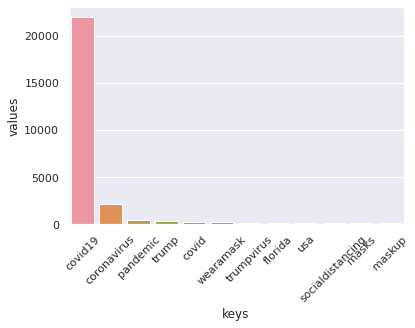

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = pd.DataFrame(freq.keys())
counts['values'] = freq.values()
counts = counts.sort_values(by = 'values', ascending = False)
counts['keys'] = counts[0]
counts_prelim = counts.head(12)
sns.barplot(x = 'keys', y = 'values', data = counts_prelim)
plt.xticks(rotation = 45)
plt.show()

As shown above, a barpolot of the overall frequencies is dominated by the first two values of "#Covid19 and #Coronavirus. In order to get a better picture of the spread, we decided to use the hashtags after these first two.

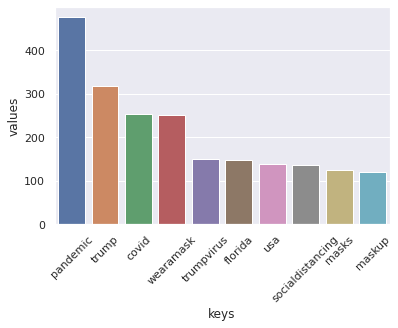

In [ ]:
counts = pd.DataFrame(freq.keys())
counts['values'] = freq.values()
counts = counts.sort_values(by = 'values', ascending = False)
counts['keys'] = counts[0]
counts_prelim = counts.head(12)
sns.barplot(x = 'keys', y = 'values', data = counts_prelim[2:])
plt.xticks(rotation = 45)
plt.show()

Some interesting values to note in the above barplot, are the ones supporting safety measures in this time such as "#wearamask", "#socialdistancing", "#masks" and "#maskup". Another intersting trend is 2 of the top 5 hashtags were those relating to Donald Trump in "#trump" and "#trumpvirus"

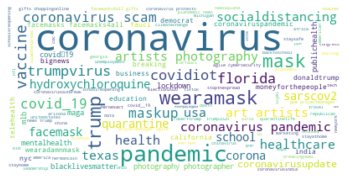

In [ ]:
ht_array = df['hashtags'].dropna().to_numpy()
def toArray(array):
  arr = []
  for i in array:
    arr.append(literal_eval(i.lower()))
  return arr
new_array = np.hstack(toArray(ht_array))
string = " ".join(new_array)
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
stopwords.update(["https", "COVID 19", "COVID19", "CO", "amp", "COVID"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(string)
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Finally we ended it with a word cloud to show off most of the relevant hashtags available in our dataset. 

###Text EDA###

As with our hashtags, we also counted the number of times specific words appeared and dispalyed the frequencies below in a barplot and word cloud. 

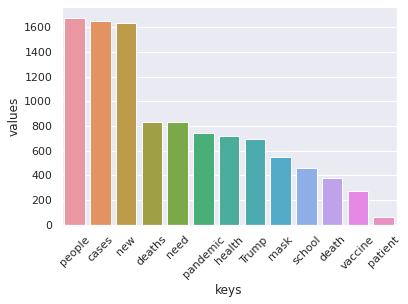

In [ ]:
counts = pd.DataFrame(freq2.keys())
counts['values'] = freq2.values()
counts = counts.sort_values(by = 'values', ascending = False)
counts['keys'] = counts[0]
counts_prelim = counts.head(20)
sns.barplot(x = 'keys', y = 'values', data = counts_prelim)
plt.xticks(rotation = 45)
plt.show()

Some interesting new words that show up are cases and deaths become a lot more frequent (mostly due to COVID 19 update tweets) as well as Trump and mask showing up frequently in the text as well.

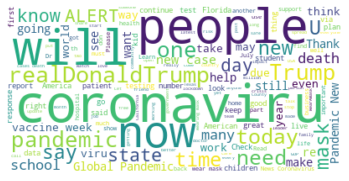

In [ ]:
import numpy as np
from ast import literal_eval
text_array = df['text'].dropna().to_numpy()
def splitArray(array):
  arr = []
  for i in array:
    arr.append(i.split())
  return arr
text_array = splitArray(text_array)
text_array
new_array = np.hstack((text_array))
new_array
string = " ".join(new_array)
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
stopwords.update(["https", "COVID 19", "COVID19", "CO", "amp", "COVID"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(string)
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Finally, we finish it with a word cloud in order to show off the frequencies of text. Some words such as COVID 19 were excluded in as they show up frequently in the text and take up a majority of the graph. 

##HeatMap EDA (Political Sentiment)##


We were further interested in seeing how states represented different political sentiment.

Using Vader, we determined the compound, negative, and positive score for each tweet below, and added them as columns to our dataframe.

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df['text']]
df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df['text']]
df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df['text']]

We then determined the number of references to political figures (one set being pro-mask and the other set being anti-mask) in each of the tweets, and added them as extra columns to our dataframe. 

In [ ]:
def countAppearancesRep(argument):
  return argument.count("Trump") + argument.count("trump") + argument.count("giulani") + argument.count("Giulani") + argument.count("Pence") + argument.count("pence")

def countAppearancesDem(argument):
  return argument.count("Biden") + argument.count("biden") + argument.count("harris") + argument.count("Harris")

In [ ]:
df["anti_mask_politicians"] = df["text"].apply(lambda x: countAppearancesRep(x))
df["pro_mask_politicians"] = df["text"].apply(lambda x: countAppearancesDem(x))

Finally, we gave two scores for each of the tweets.


> The **rep_score** is calculated as the score for the negative sentiment of the tweet multiplied by the number of references to pro-mask politicians plus the the score for the positive sentiment of the tweet multiplied by the number of references to anti-mask politicians.



> The **dem_score** is calculated as the score for the negative sentiment of the tweet multiplied by the number of references to anti-mask politicians plus the the score for the positive sentiment of the tweet multiplied by the number of references to pro-mask politicians.





In [ ]:
df["rep_score"] = (df["neg"] * df["pro_mask_politicians"]) + (df["pos"] * df["anti_mask_politicians"])
df["dem_score"] = (df["neg"] * df["anti_mask_politicians"]) + (df["pos"] * df["pro_mask_politicians"])

We group the data by state and get the mean for insights

In [ ]:
from matplotlib import pyplot as plt

well = df.groupby(by=["user_location"]).mean()
well

,user_followers,user_friends,user_favourites,user_verified,is_retweet,covid19_hashtag,coronavirus_hashtag,pandemic_hashtag,trump_hashtag,covid_hashtag,wearamask_hashtag,trumpvirus_hashtag,florida_hashtag,usa_hashtag,socialdistancing_hashtag,masks_hashtag,maskup_hashtag,vaccine_hashtag,scams_hashtag,covid_19_hashtag,people_text,cases_text,new_text,deaths_text,need_text,pandemic_text,health_text,Trump_text,mask_text,school_text,death_text,vaccine_text,compound,neg,pos,anti_mask_politicians,pro_mask_politicians,rep_score,dem_score
user_location,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,9801.900000,2026.275000,36622.108333,0.041667,0.0,0.541667,0.050000,0.025000,0.041667,0.541667,0.016667,0.008333,0.008333,0.000000,0.008333,0.016667,0.016667,0.016667,0.000000,0.000000,0.025000,0.058333,0.216667,0.016667,0.008333,0.016667,0.025000,0.0,0.041667,0.066667,0.025000,0.016667,0.107142,0.078342,0.105892,0.175000,0.008333,0.011467,0.010967
AL,9273.979550,1552.574642,8043.599182,0.319018,0.0,0.554192,0.073620,0.014315,0.024540,0.554192,0.002045,0.002045,0.004090,0.004090,0.002045,0.006135,0.002045,0.006135,0.000000,0.004090,0.051125,0.120654,0.294479,0.049080,0.018405,0.028630,0.059305,0.0,0.083845,0.030675,0.075665,0.016360,0.065472,0.059417,0.085252,0.042945,0.012270,0.003528,0.005098
AR,8207.000000,5339.664502,23626.411255,0.080087,0.0,0.590909,0.054113,0.021645,0.021645,0.599567,0.010823,0.004329,0.006494,0.004329,0.004329,0.008658,0.002165,0.002165,0.000000,0.004329,0.043290,0.080087,0.101732,0.006494,0.017316,0.019481,0.162338,0.0,0.155844,0.047619,0.023810,0.004329,0.152576,0.049630,0.095634,0.077922,0.008658,0.005877,0.012693
AZ,19814.080395,2373.905501,17510.019746,0.094499,0.0,0.534556,0.055007,0.012694,0.025388,0.538787,0.005642,0.002821,0.008463,0.002821,0.008463,0.009873,0.004231,0.009873,0.001410,0.001410,0.057828,0.028209,0.074753,0.038082,0.021157,0.042313,0.042313,0.0,0.042313,0.040903,0.050776,0.012694,0.050073,0.065652,0.082787,0.117066,0.035261,0.009698,0.016150
CA,9547.815280,2812.207919,20518.578406,0.099948,0.0,0.551893,0.066457,0.016047,0.027211,0.555381,0.006105,0.003837,0.004186,0.005582,0.002791,0.004710,0.004710,0.006279,0.003837,0.003663,0.061050,0.051980,0.109716,0.032095,0.037328,0.058259,0.068027,0.0,0.056340,0.023025,0.043433,0.020059,0.050730,0.065162,0.086663,0.108844,0.017617,0.008766,0.014101
CO,10833.430595,5963.328612,26725.205382,0.075071,0.0,0.552408,0.052408,0.012748,0.032578,0.555241,0.007082,0.004249,0.001416,0.004249,0.002833,0.002833,0.004249,0.011331,0.000000,0.002833,0.070822,0.026912,0.062323,0.018414,0.033994,0.070822,0.050992,0.0,0.070822,0.049575,0.029745,0.007082,0.062418,0.065700,0.087990,0.097734,0.008499,0.007552,0.008854
CT,18724.194748,5379.739606,22998.993435,0.078775,0.0,0.536105,0.067834,0.013129,0.024070,0.538293,0.004376,0.004376,0.002188,0.004376,0.004376,0.008753,0.006565,0.004376,0.002188,0.002188,0.052516,0.039387,0.124726,0.041575,0.039387,0.102845,0.056893,0.0,0.054705,0.024070,0.048140,0.019694,0.089933,0.059173,0.093630,0.074398,0.010941,0.007350,0.008737
DC,98593.317024,3163.733899,15453.786820,0.311033,0.0,0.545182,0.059910,0.015976,0.024963,0.548677,0.004493,0.005492,0.001997,0.001997,0.000499,0.006990,0.003495,0.004493,0.002496,0.003994,0.055916,0.038942,0.096355,0.022966,0.041438,0.067898,0.072891,0.0,0.030954,0.035946,0.035946,0.027958,0.039971,0.067919,0.084090,0.050924,0.006490,0.003623,0.006271
DE,19467.424084,18452.560209,1957.895288,0.009424,0.0,0.544503,0.067016,0.015707,0.026178,0.546597,0.006283,0.003141,0.001047,0.004188,0.007330,0.011518,0.004188,0.006283,0.005236,0.005236,0.017801,0.095288,0.633508,0.043979,0.005236,0.595812,0.027225,0.0,0.065969,0.046073,0.060733,0.028272,0.181535,0.080580,0.143939,0.053403,0.012565,0.008275,0.007472


We then plot the data

In [ ]:
states = well.index.values.tolist()
rep_score = pd.Series.tolist(well["rep_score"])
dem_score = pd.Series.tolist(well["dem_score"])
compound_score = pd.Series.tolist(well["compound"])

In [ ]:
import plotly.graph_objects as go

# fig = px.choropleth(locations=states, locationmode="USA-states", color=rep_score, scope="usa")
fig = go.Figure(data=go.Choropleth(
    locations=states, # Spatial coordinates
    z = rep_score, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Republican Score",
))

fig.update_layout(
    title_text = 'Republican Positive Sentiment',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

The data seems correct! 

States like Florida, Pennsylvania, Texas, and Montana have a strong republican score, as the 2020 election results have confirmed. 

States like CA are still a reddish color since more tweets come from that region. However, the intensity of the color relative to other states still corresponds to a correct political sentiment. 

In [ ]:
# fig = px.choropleth(locations=states, locationmode="USA-states", color=rep_score, scope="usa")
fig = go.Figure(data=go.Choropleth(
    locations=states, # Spatial coordinates
    z = dem_score, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Democratic Score",
))

fig.update_layout(
    title_text = 'Democratic Positive Sentiment',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

Though we were surprised with the results at first, we realized that states like Florida and Pennsylvania had both a strong democratic score AND a strong republican score since they were swing states. Moreover, it made sense that they had both strong positive Republican and Democratic sentiment.

States like Texas, Montana, Alaska, and Nebraska showed a significant dip in color intensity from the Republican Positive Sentiment, as it should.

WI was a pivotal swing state for the 2020 election, and our map correctly shows that (based on tweets) that it turned blue (as the 2020 election showed).

*We have confirmed that our data follows typical US state political trends with our heatmaps.*

We were also interested in what the compound score (sentiment from Vader) was for each state.

In [ ]:
# fig = px.choropleth(locations=states, locationmode="USA-states", color=rep_score, scope="usa")
fig = go.Figure(data=go.Choropleth(
    locations=states, # Spatial coordinates
    z = compound_score, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'peach',
    colorbar_title = "Compound Score",
))

fig.update_layout(
    title_text = 'Compound (Pos/Neg) Sentiment',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

This plot was very interesting; It seemed like across all the states, all of the positive and negative tweets balanced each other out, placing the compound values near 0. This does NOT mean that the Republican and Democratic Sentiment cancels each other out (since we are strictly using Vader's compound score), but rather that the positive and negative tweets cancel each other out. 

Apparently Idaho is one of happiest states in the nation... and our data interestingly shows this as true here - quite proudly.

https://www.ktvb.com/article/news/local/idaho/idaho-ranked-among-happiest-states-in-the-nation/277-595888169

In all seriousness, we assume this is true because the dataset batch we received just had more positive sentiment tweets for both Republicans and Democrats

## Time EDA ##

We were finally interested in seeing the trends of keywords and sentiment throughout time.

The tags dataframe contains all of the text and hashtag related frequencies (by mean).

The sent dataframe contains all of the sentiment related frequencies (by mean). 

In [ ]:
temp = df
temp = temp.groupby(by=["date"]).mean()
tags = temp.drop(["user_followers", "user_friends", "user_favourites", "user_verified", "is_retweet", "compound", "neg", "pos", "anti_mask_politicians", "pro_mask_politicians", "rep_score", "dem_score"], axis=1)
sent = temp.drop(["user_followers", "user_friends", "user_favourites", "user_verified", "is_retweet", "covid19_hashtag", "coronavirus_hashtag", "pandemic_hashtag", "trump_hashtag", "covid_hashtag", "wearamask_hashtag", "trumpvirus_hashtag", "florida_hashtag", "usa_hashtag", "socialdistancing_hashtag", "masks_hashtag", "maskup_hashtag", "vaccine_hashtag", "scams_hashtag", "covid_19_hashtag", "people_text", "cases_text", "new_text", "deaths_text", "need_text", "pandemic_text", "health_text", "Trump_text", "mask_text", "school_text", "death_text", "vaccine_text"], axis=1)

Tags Plot


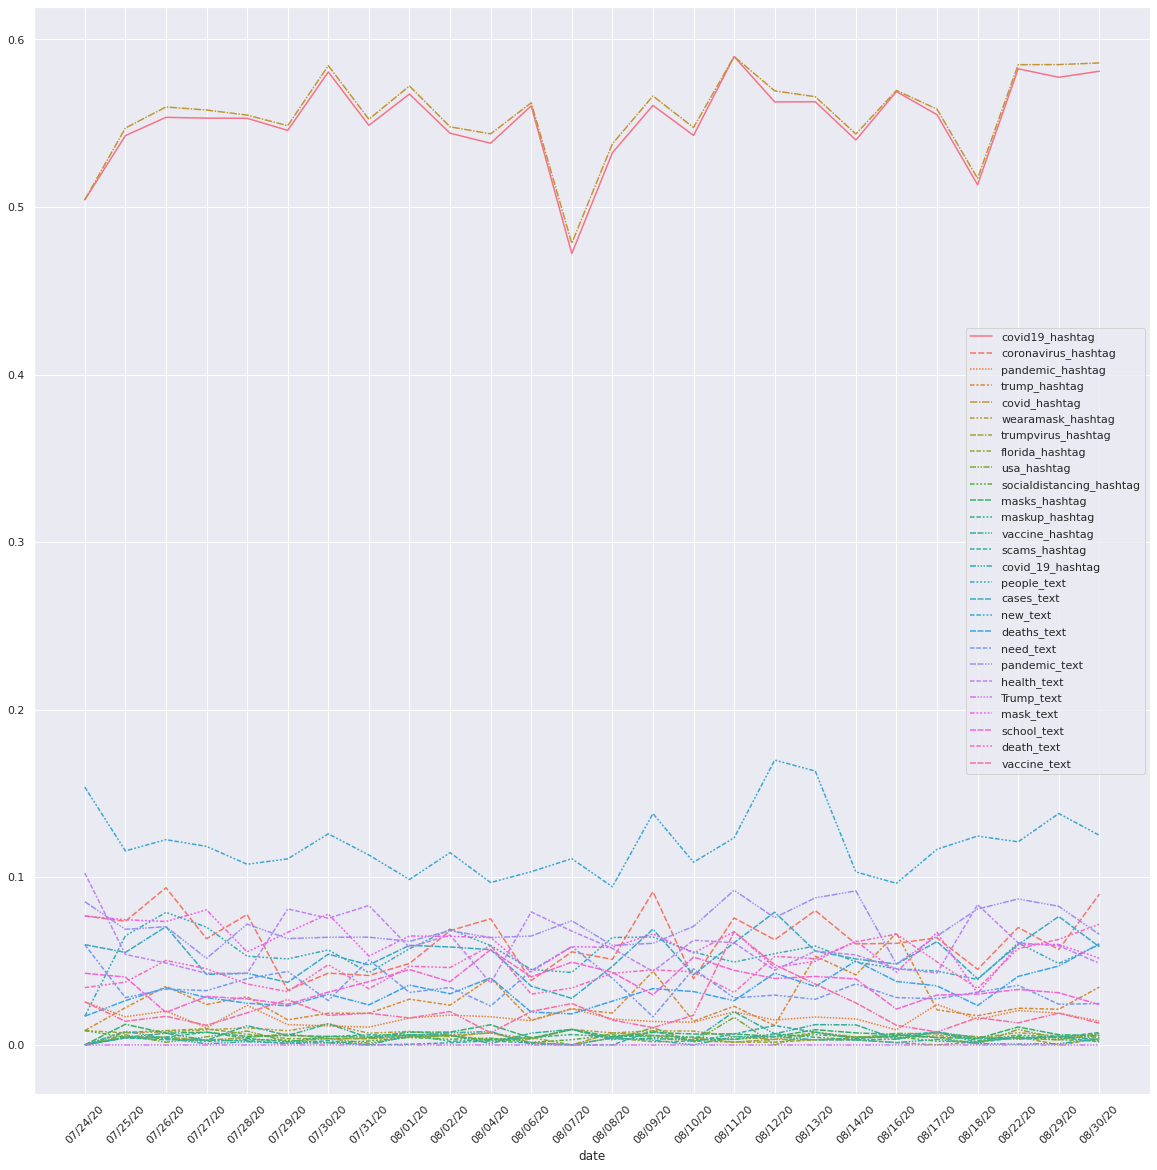

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

plt.figure(figsize=(20, 20))
sns.lineplot(data=tags)
plt.xticks(rotation = 45)
plt.show()

We can see that covid19 and coronavirus were consistently mentioned at a high frequency. Interestingly, the frequency of words seem to be zig-zaggy, similar to how the actual number of COVID cases are reported. 



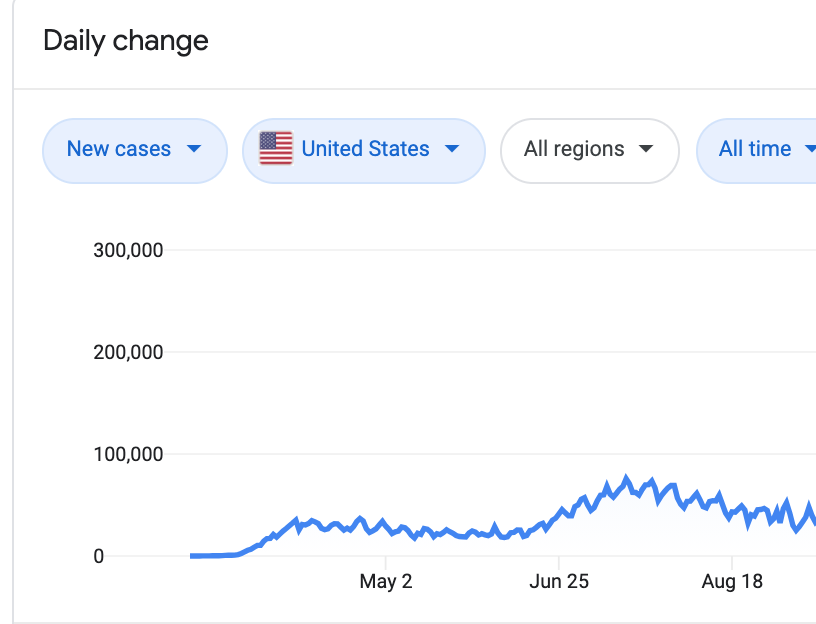

The lines also seem to fit an overall trend that has a similar shape to the actual number of cases reported. For new_text we can also see a spike around mid-August, which was when we saw a rise in the number of cases.

Sentiment Plot

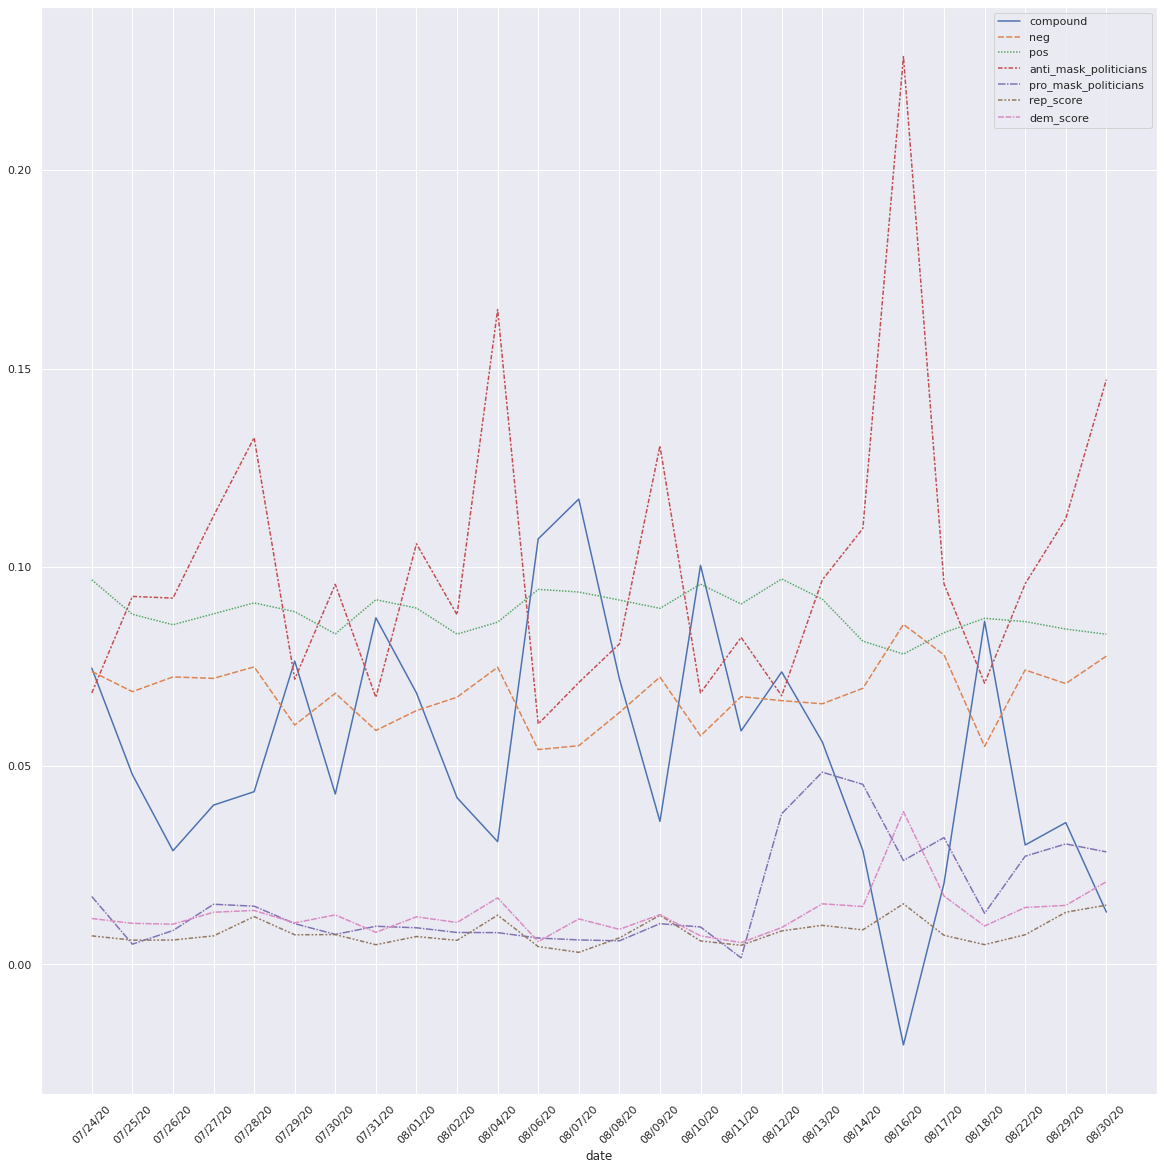

In [ ]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(20, 20))
sns.lineplot(data=sent)
plt.xticks(rotation = 45)
plt.show()

This plot also shows a zig-zaggy trend with positivie sentiment tweets consistently outnumbering the negative sentiment tweets in strength.

The anti mask politicians sentiment takes a huge positive spike around August 16, while the compound score takes a huge negative spike. This can possibly be explained by Trump's little brother's death on that date.



#Preprocessing for Machine Learning#

This section combines the sentiment analysis and the Hashtag/text EDA in order to get a sense of the sentiment in tweets relating to X. For example, if a tweet has #Trump and a negative sentiment, we know that it was saying negative thigns about Donald Trump in the tweet. It then drops the original boolean from the dataframe.

In [ ]:
for v in vlist:
  df[v + "_hashtag_sentiment"] = df["compound"] * df[v + "_hashtag"]
  df = df.drop([v+ "_hashtag"], axis = 1)

for v in vlist2:
  df[v + "_text_sentiment"] = df["compound"] * df[v + "_text"]
  df = df.drop([v+ "_text"], axis = 1)


Drop irrelevant data points

In [ ]:
df = df.drop(["user_description", "user_favourites", "text", "hashtags", "is_retweet", "source"], axis=1)


In [ ]:
#saving current dataframe for logistic/decision tree model later on
df_rep_dem = df

Merge our data analyzing tweets with our data about the Covid 19 cases by state


In [ ]:
df = pd.merge(df, df_cases, how="inner", left_on=['date', 'user_location'], right_on=['submission_date', 'state'])
df = df.drop(["state", "submission_date", 'conf_cases', 'prob_cases', 'new_case', 'pnew_case', 'tot_death', 'conf_death', 'prob_death', 'new_death', 'pnew_death', 'created_at', 'consent_cases', 'consent_deaths'], axis=1)

Log scale our values of user followers and user friends as some values are significantly larger than others in therse variables, so we assumed a log scale would help even the spread of the variables.

In [ ]:
df = df.drop(["date"], axis=1)
df["log_user_followers"] = np.log(df["user_followers"]).replace(-np.inf, np.nan).replace(np.inf, np.nan)

df = df.dropna(subset=["log_user_followers"])
df["log_user_friends"] = np.log(df["user_friends"]).replace(-np.inf, np.nan).replace(np.inf, np.nan)

Drop any null values created from taking the log of 0, and then drop remaining irrelevant columns

In [ ]:
df = df.dropna(subset=["log_user_friends"])
df = df.drop(["user_friends", "user_followers"], axis=1)
df = df.drop(["anti_mask_politicians", "pro_mask_politicians"], axis=1)

In [ ]:
#creating a dataframe to test without the states
df_without_states = df

one_hot = pd.get_dummies(df.user_location)
df = pd.concat([df, one_hot], axis=1)

In [ ]:
df = df.drop(["user_location"], axis=1)
df_without_states = df_without_states.drop(["user_location"], axis=1)

# **Modelling**

## 1. Predicting the number of deaths that will occur in the location of a given tweet

###Linear Regression###

Linear Regression to test correlation of variables without states


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Your code goes here
label = df_without_states['tot_cases']
features = df_without_states.drop(['tot_cases'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = .2) 
transformed = x_train
# x_train = preprocessing.scale(x_train)
# x_test = preprocessing.scale(x_test)
y_train = np.log(y_train)
y_test = np.log(y_test)

In order to get a sense of the value that each individual value was adding to our model, we decided to first use Statsmodel and perform a linear regression through their API. Some important things to note about this model, it is not to be used for predictive power (no train/test split), and should only be used to measure the correlation between our variables and the total cases. This however can lead to evidence that there might be predictive power in the next section. A high R^2 and adjusted R^2 value shows that there is correlation between our variables and total cases. Looking at individual variables, it seems as though the sentiment of the text was more influential than the sentiment of the hashtags.

In [ ]:
import statsmodels.api as sm


yvar = y_train
xvar = x_train
res = sm.OLS(yvar.astype(float), xvar.astype(float)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              tot_cases   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.931
Method:                 Least Squares   F-statistic:                          1.264e+04
Date:                Tue, 15 Dec 2020   Prob (F-statistic):                        0.00
Time:                        17:30:31   Log-Likelihood:                         -80481.
No. Observations:               31632   AIC:                                  1.610e+05
Df Residuals:                   31598   BIC:                                  1.613e+05
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
user_verified                         -0.8243      0.066    -12.541      0.000      -0.953      -0.696
compound                               0.2706      0.155      1.749      0.080      -0.033       0.574
neg                                    4.3209      0.403     10.714      0.000       3.530       5.111
pos                                    5.0804      0.386     13.172      0.000       4.324       5.836
rep_score                             -0.9880      0.378     -2.611      0.009      -1.730      -0.246
dem_score                              0.1096      0.281      0.391      0.696      -0.441       0.660
covid19_hashtag_sentiment              0.2602      0.714      0.365      0.715      -1.138       1.659
coronavirus_hashtag_sentiment          0.0678      0.175      0.387      0.699      -0.276       0.411
pandemic_hashtag_sentiment             0.0201      0.337      0.060      0.952      -0.640       0.680
trump_hashtag_sentiment               -0.4668      0.278     -1.678      0.093      -1.012       0.079
covid_hashtag_sentiment               -0.3203      0.714     -0.448      0.654      -1.720       1.080
wearamask_hashtag_sentiment            0.0703      0.491      0.143      0.886      -0.893       1.033
trumpvirus_hashtag_sentiment           0.2186      0.676      0.323      0.747      -1.107       1.544
florida_hashtag_sentiment              0.1685      0.677      0.249      0.804      -1.159       1.496
usa_hashtag_sentiment                 -0.1909      0.707     -0.270      0.787      -1.577       1.195
socialdistancing_hashtag_sentiment     0.7222      0.717      1.007      0.314      -0.684       2.128
masks_hashtag_sentiment               -0.1430      0.503     -0.284      0.776      -1.129       0.843
maskup_hashtag_sentiment               1.1421      0.632      1.806      0.071      -0.097       2.382
vaccine_hashtag_sentiment              0.1335      0.532      0.251      0.802      -0.910       1.177
scams_hashtag_sentiment                1.1234      0.718      1.564      0.118      -0.284       2.531
covid_19_hashtag_sentiment             2.2976      0.784      2.930      0.003       0.761       3.834
people_text_sentiment                 -0.3175      0.167     -1.906      0.057      -0.644       0.009
cases_text_sentiment                   0.6202      0.235      2.642      0.008       0.160       1.080
new_text_sentiment                    -1.3001      0.143     -9.072      0.000      -1.581      -1.019
deaths_text_sentiment                 -0.1325      0.376     -0.353      0.724      -0.869       0.604
need_text_sentiment                    0.0422      0.230      0.184      0.854      -0.408       0.4

For our actual predictive modelling of the data, we decided to use sklearn linear regression in order to test to see if we can predict the number of cases based on our variables. First we decided to split our data into train and testing data. We also took the log scale of the number of cases because of the large differences in values between some states (For example Florida and Alaska)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Your code goes here
label = df['tot_cases']
features = df.drop(['tot_cases'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = .2) 
transformed = x_train
y_train = np.log(y_train)
y_test = np.log(y_test)

In [ ]:
print(f'Mean of Florida: {df.groupby("FL")["tot_cases"].mean()[1]}')
print(f'Mean of Alaska: {df.groupby("AK")["tot_cases"].mean()[1]}')

Mean of Florida: 502001.7577720207
Mean of Alaska: 3636.741666666667


Since we had a lot of testing variables, and some may overlap still even after removing a good amount, we decided to use PCA. We are looking to reduce our amount of variables without reducing too much of the variance explained. We felt a happy medium between these two were around 50 components. 

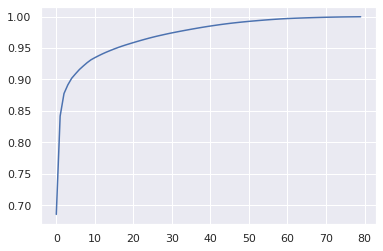

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Your code goes here
pca = PCA(n_components = 80)
pca_transformed = pca.fit_transform(transformed)
ncompenents = range(80)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(ncompenents, cumsum)


Using our 50 variables from the PCA, we decided to perform a linear regression model. 

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


pca = PCA(n_components = 50)
x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

clf = LinearRegression()
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

mse_train = mean_squared_error(y_train, clf.predict(x_train))

mse_test = mean_squared_error(y_test, y_pred)

In [ ]:
mse_test

0.7272165030927217

In [ ]:
clf.score(x_train, y_train)

0.8921530963240946

In [ ]:
clf.score(x_test, y_test)

0.5374352416430719

With a score of around 50% on our testing data, it seems that there is some evidence that information collected through Twitter can be used to help predict the number of cases to be expected in an area. In other words, the perception of Coronavirus in an area has some predictive power in the amount of cases to be expected in the area. 

## 2. Predicting whether a tweet comes from a republican or democratic state ##

Preprocessing Data

We normalize the data to minimize differences

In [ ]:
df_rep_dem = df_rep_dem.drop(["date"], axis=1)
df_rep_dem["log_user_followers"] = np.log(df_rep_dem["user_followers"]).replace(-np.inf, np.nan).replace(np.inf, np.nan)

df_rep_dem = df_rep_dem.dropna(subset=["log_user_followers"])
df_rep_dem["log_user_friends"] = np.log(df_rep_dem["user_friends"]).replace(-np.inf, np.nan).replace(np.inf, np.nan)

In [ ]:
df_rep_dem = df_rep_dem.dropna(subset=["log_user_friends"])
df_rep_dem = df_rep_dem.drop(["user_friends", "user_followers"], axis=1)
df_rep_dem = df_rep_dem.drop(["anti_mask_politicians", "pro_mask_politicians"], axis=1)

We add the label of the dataset as the traditional political viewpoints of states. 

Moreover, we use this dictionary to tranform our "user_location" column into the label for our machine learning model.

In [ ]:
us_pol = {
    'AL' : "red",
    'AK' : "red",
    'AZ': "red",
    'AR' : "red",
    'CA': "blue",
    'CO': "blue",
    'CT': "blue",
    'DE': "blue",
    'DC': "blue",
    'FL' : "red",
    'GA': "red",
    'HI': "blue",
    'ID' : "red",
    'IL': "blue",
    'IN' : "red",
    'IA' : "red",
    'KS' : "red",
    'KY' : "red",
    'LA' : "red",
    'ME' : "blue",
    'MD': "blue",
    'MA': "blue",
    'MI': "red",
    'MN': "blue",
    'MS' : "red",
    'MO' : "red",
    'MT' : "red",
    'NE' : "red",
    'NV': "blue",
    'NH' : "blue",
    'NJ': "blue",
    'NM': "blue",
    'NY': "blue",
    'NC' : "red",
    'ND' : "red",
    'OH' : "red",
    'OK' : "red",
    'OR': "blue",
    'PA': "red",
    'RI': "blue",
    'SC' : "red",
    'SD' : "red",
    'TN' : "red",
    'TX' : "red",
    'UT' : "red",
    'VT': "blue",
    'VI' : "red",
    'VA' : "red",
    'WA' : "blue",
    'WV' : "red",
    'WI': "red",
    'WY' : "red",
    "PR" : "blue",
    "GU" : "red"
}

In [ ]:
test = df_rep_dem.copy()
def conv(targ):
  return us_pol[targ]

In [ ]:
test['user_location'] = test['user_location'].apply(lambda x: conv(x))

Thus, we can see below that our user_location is now labeled as "Red" or "Blue" for the label

In [ ]:
test

,user_location,user_verified,compound,neg,pos,rep_score,dem_score,covid19_hashtag_sentiment,coronavirus_hashtag_sentiment,pandemic_hashtag_sentiment,trump_hashtag_sentiment,covid_hashtag_sentiment,wearamask_hashtag_sentiment,trumpvirus_hashtag_sentiment,florida_hashtag_sentiment,usa_hashtag_sentiment,socialdistancing_hashtag_sentiment,masks_hashtag_sentiment,maskup_hashtag_sentiment,vaccine_hashtag_sentiment,scams_hashtag_sentiment,covid_19_hashtag_sentiment,people_text_sentiment,cases_text_sentiment,new_text_sentiment,deaths_text_sentiment,need_text_sentiment,pandemic_text_sentiment,health_text_sentiment,Trump_text_sentiment,mask_text_sentiment,school_text_sentiment,death_text_sentiment,vaccine_text_sentiment,log_user_followers,log_user_friends
0,blue,True,0.2263,0.057,0.093,0.0,0.000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,7.720018,7.424762
1,red,False,-0.2732,0.104,0.000,0.0,0.208,-0.2732,-0.0,-0.0,-0.0,-0.2732,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0000,-0.0000,-0.0000,-0.0,-0.0,-0.0,-0.0,-0.00,-0.0,-0.0000,-0.0,9.135078,9.161675
2,red,False,0.0000,0.000,0.000,0.0,0.000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,11.289232,10.911628
3,red,False,0.3612,0.000,0.116,0.0,0.000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,2.639057,3.178054
4,blue,True,0.0000,0.000,0.000,0.0,0.000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,9.274348,1.791759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39776,red,False,-0.4466,0.140,0.000,0.0,0.000,-0.4466,-0.0,-0.0,-0.0,-0.4466,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.4466,-0.4466,-0.4466,-0.0,-0.0,-0.0,-0.0,-0.00,-0.0,-0.4466,-0.0,7.150701,6.954639
39777,blue,False,0.2500,0.000,0.087,0.0,0.000,0.2500,0.0,0.0,0.0,0.2500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.25,0.0,0.0000,0.0,7.671361,6.981935
39778,blue,False,0.0000,0.000,0.000,0.0,0.000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,5.814131,3.784190
39779,blue,False,0.0000,0.000,0.000,0.0,0.000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.00,0.0,0.0000,0.0,8.744169,5.087596


We check below to see if our data is relatively evenly spread out. 

With this, we will be able to make sure that our classifier does not just prioritize guessing one over the other just based on the frequency.

In [ ]:
test['user_location'].value_counts()

blue    22088
red     17453
Name: user_location, dtype: int64

### Logistic Regression ###

We first fit a logistic regression to the model since we believed that it will predict the labels best.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



array([[3725,  651],
       [2872,  661]])

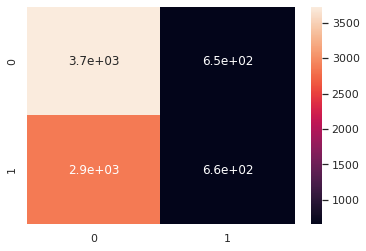

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

label = test['user_location']
features = test.drop(['user_location'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = .2) 

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(x_train, y_train)
y_predict = clf.predict(x_test)

clf.score(x_train, y_train)
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, y_predict)
sns.heatmap(cf_matrix, annot=True)
confusion_matrix(y_test, y_predict)

In [ ]:
clf.classes_

array(['blue', 'red'], dtype=object)

Unfortunately, the values do not converge, and the majority of the guesses are going to the negatives (blue) . Moreover, logistic regression does not seem to match with our data. 

In [ ]:
clf.score(x_test, y_test)

0.5718801365532937

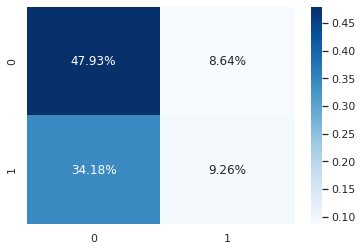

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

### Random Forest ###

We decided to use a Random Forest model after Logistic Regression failed, and since, in practice, should give the best immediate results.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import tree
from sklearn.metrics import confusion_matrix


label = test['user_location']
features = test.drop(['user_location'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = .2) 

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(x_train, y_train)


y_predict = clf.predict(x_test)
confusion_matrix(y_test, y_predict)

array([[4171,  275],
       [2938,  525]])

Below, we can see that our model unfortunately over predicts on the negatives. Thought the clf fit does better than guessing (50%), our model puts too much weight on guessing blue.

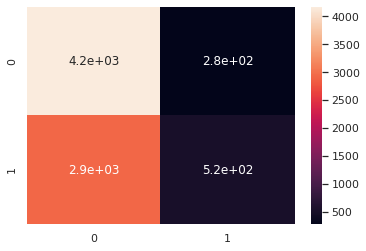

In [ ]:
cf_matrix = confusion_matrix(y_test, y_predict)
sns.heatmap(cf_matrix, annot=True)

In [ ]:
clf.score(x_test, y_test)

0.5937539511948413

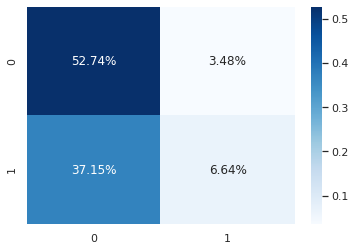

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

As shown above, the percentages of the guesses are nearly 90% favored towards negative, and thus the model is getting a huge value for false negatives. A possible explanation for this is that when decision trees "split up" and "aggregate" the best predictive model by majority voting, accuracy diminishes for our specific model. Moreover, we used a more direct approach using a decision tree. 

### Decision Tree ###

With the failure of Random Forests, we thought that a more direct, complete approach with a decision tree would give us better values. 

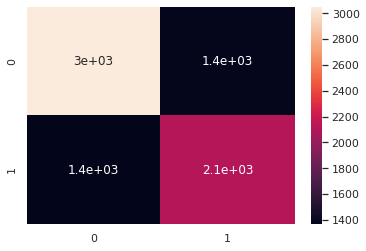

In [ ]:
from sklearn import tree
from sklearn.metrics import confusion_matrix
import seaborn as sns

label = test['user_location']
features = test.drop(['user_location'], axis=1)


x_train, x_test, y_train, y_test = train_test_split(features, label, test_size = .2) 

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)


#predicting and plotting confusion matrix
y_predict = clf.predict(x_test)
cf_matrix = confusion_matrix(y_test, y_predict)
sns.heatmap(cf_matrix, annot=True)


Our model has much better predictive power!

Based on the confusion matrix, we can see that most of the correct guesses are coming from the True Negatives (blue). Also, our model is able to predict True Positives (red) to a favorable degree as well.

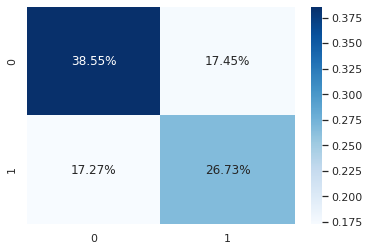

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Above, we can see where the percentages of predictions lie. 

In [ ]:
clf.score(x_test, y_test)

0.6528006069035276

# Challenges and Future Direction


Overall, we are happy with our results but our models can definitely improve their predictive power. We were met with the following challenges:



1.   When extracting data, we were met with the challenge of extracting the state locations off of Twitter. We were able to extract around 40, 000 rows of data by matching keywords. However, some of these states may be innacurate (for example, some users may put random characters in their location such as "ALLO!" in which our model may incorrectly interpret as being "Alabama" with the AL keyword in it). Moreover, a future potential step may be to get more data on the location based on the tweet itself. 
2. One possible concern with the linear regression is the state adding the predictive power for our combined model. Are the states so diversified in their Covid-19 cases that only knowing the state would be enough to get a similar model? Some future analysis would involve looking at trends within specific states that had spikes in Covid 19 cases. For example, how did the sentiment of Covid-19 in Florida change after the reopening of restaraunts and Disney Land in Florida and the subsequent rise of Covid-19 cases in the state. Could this relationship be used to predict number of cases
3.   When our random forest model did not work at first, we were confused at the implications of our model. Upon fixing the issue with our decision tree, we wonder if the problem was caused by uneven weighting of features across different rows of our data. Moreover, a future step would be to explore the predictive power of different features among different subsets of data, and figure out the best model from there. 

4. Our data, after cleaning, had dates ranging around a month. We believe that the optimal model would have dates longer than this range, and also closer in proximity to the present time. A future step would be to obtain data through our own scraper instead of using tweets that are a few months older. 


